In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
1/2 * 32768

16384.0

In [3]:
wavelen = 10000
x = arange(wavelen)
gradRising = 10
gradRisingInv = int((1/gradRising) * 32768)
triPeakPoint = (wavelen * gradRisingInv) >> 15
gradFalling = ((1/(1 - (1/gradRising))))
gradRising = int(gradRising * 32768)
gradFalling = int(gradFalling * 32768)
[gradRising, gradFalling, gradRisingInv, triPeakPoint]

[327680, 36408, 3276, 999]

In [4]:
y = zeros_like(x)
for i in range(len(x)):
    v = x[i]
    if (i < triPeakPoint):
        v = (v * gradRising) >> 15
    else:
        v = wavelen - (int((v-triPeakPoint) * gradFalling) >> 15)
    y[i] = v
    

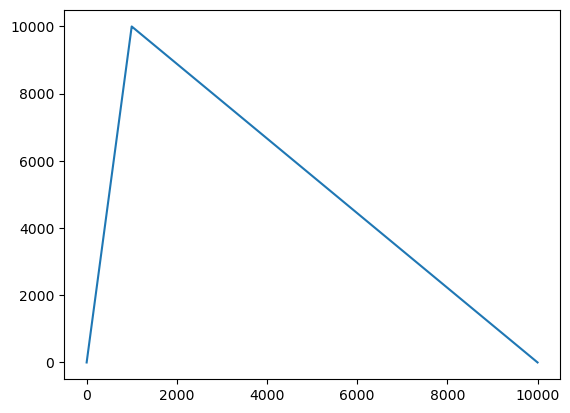

In [5]:
plot(y)

In [7]:
#bit expts

#err manipulation

#aim - want nonlinear reaction to frequency, possible long term effects using feedback going beyond wavelenth

In [264]:
y=0
err=0
phase=0
sr = 1_000_000
wavelen = int(sr / 300)
cycles = 40


gradRising = 2
gradRisingInv = int((1/gradRising) * 32768)
triPeakPoint = (wavelen * gradRisingInv) >> 15
gradFalling = ((1/(1 - (1/gradRising))))
gradRising = int(gradRising * 32768)
gradFalling = int(gradFalling * 32768)
print([gradRising, gradFalling, gradRisingInv, triPeakPoint, wavelen])

bs = np.zeros(cycles * wavelen, dtype=uint8)
errs = np.zeros(cycles * wavelen, dtype=int)
thr=0

for i in range(len(bs)):
    #phase
    phase = phase + 1
    if (phase >= wavelen):
        phase=0

    amp = phase * 2
    if (amp > wavelen):
        amp = phase

    #double saw
    # y = 1 if amp >= err else 0
    # if (phase < wavelen//4):
    #     err = ((wavelen) if y else 0) - amp + err
    # else:
    #     err = ((int(wavelen * 2.3)<<1) if y else 0) - amp + err

    #half rect 
    # y = 1 if amp >= thr else 0
    # err = ((wavelen) if y else 0) - amp + err
    # alpha=0.01
    # thr = (err * alpha) + (thr * (1-alpha))

    #smmoth with rate limit
    y = 1 if amp >= err else 0
    newerr = ((wavelen) if y else 0) - amp + err
    lim=int(wavelen * 0.3)
    if ((newerr-err)> lim):
        newerr = err + lim
    err=newerr
    
    
    bs[i] = int(y)
    errs[i] = err

[65536, 65536, 16384, 1666, 3333]


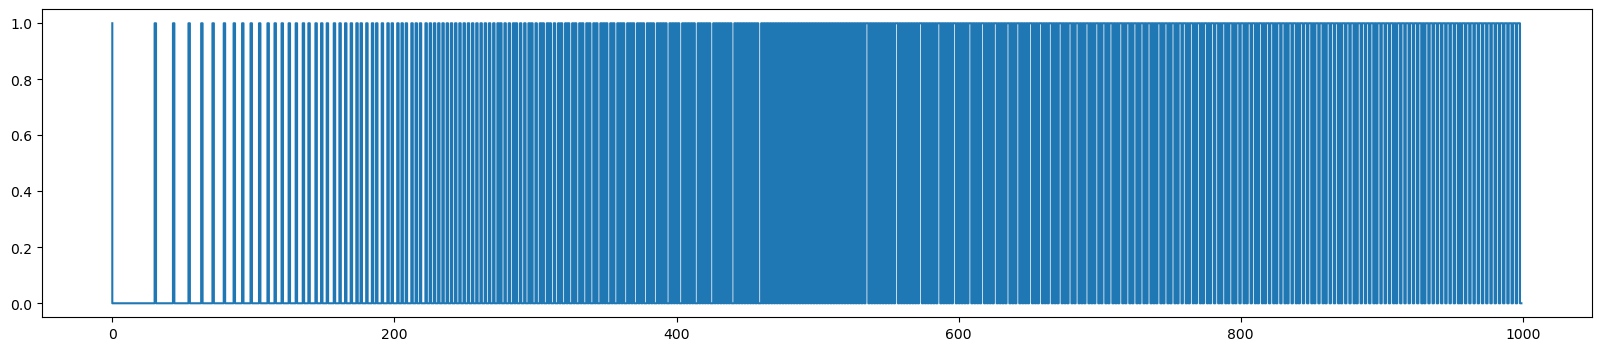

In [265]:
figsize(20,4)
winstart=0
windowLen = 1000
step(arange(windowLen-winstart),bs[winstart:windowLen])


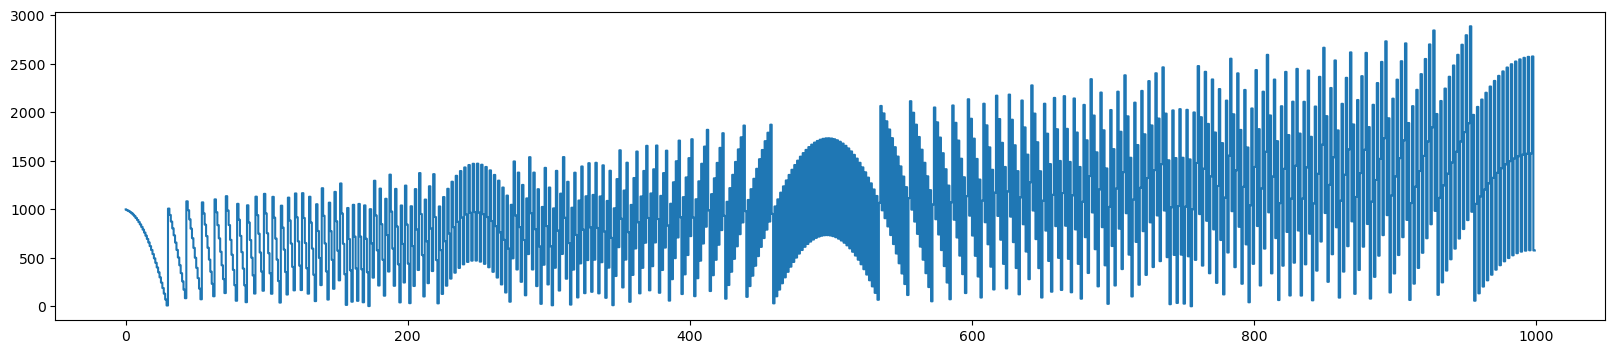

In [266]:
step(arange(windowLen-winstart),errs[winstart:windowLen])

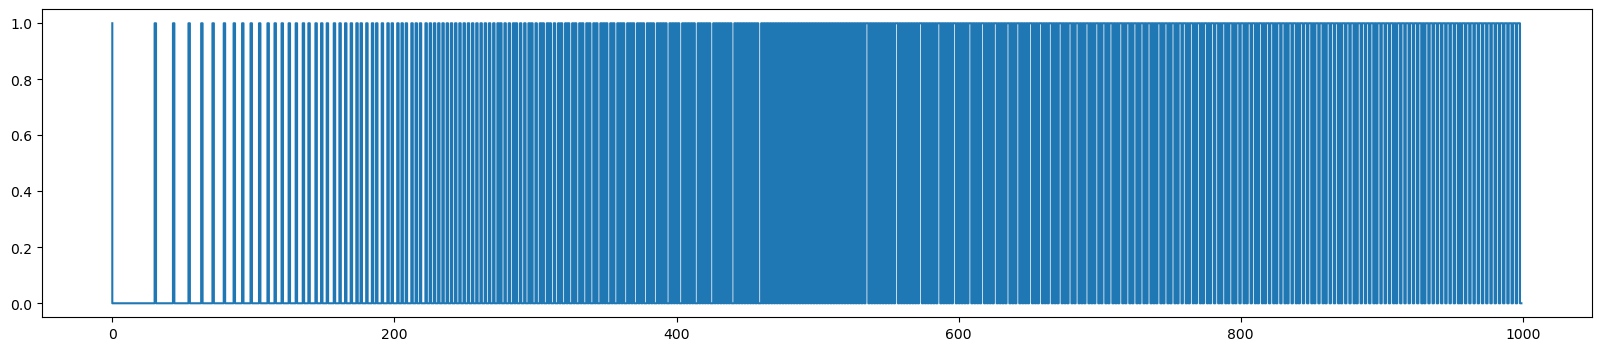

In [267]:
def pack32(bits):
    v=0
    idx=len(bits)-1
    for bit in bits:
        v = v | (bit << idx)
        idx = idx - 1
    return v

pack32(bs[:32])

#bit processing
#pack stream into 32 bit words
numWords = len(bs)//32
bs32 = zeros(numWords, dtype=uint32)
for i in range(numWords):
    # bs32[i] = pack32(bs[i*32:(i+1)*32])
    bs32[i] = pack32(bs[i*32:(i+1)*32])



#bit processing

bs32Processed = zeros_like(bs32)
for i in range(numWords-2):
    # bs32Processed[i] = (bs32[i] | 0b1010101010001000_10101000_10101000)
    bs32Processed[i] = bs32[i] 
    # bs32Processed[i] = bs32[i] << (i % 31) #get shift from wavetable over n*wavelen
    # bs32Processed[i] = bs32[i] << (i % 31)
    # bs32Processed[i] = bs32[i]



#unpack
bsunpack = zeros_like(bs)
idx=0
for i in range(numWords):
    for j in range(32):
        bsunpack[idx] = (bs32Processed[i] >> (31-j)) & 1
        idx = idx + 1   
        

step(arange(windowLen),bsunpack[:windowLen])

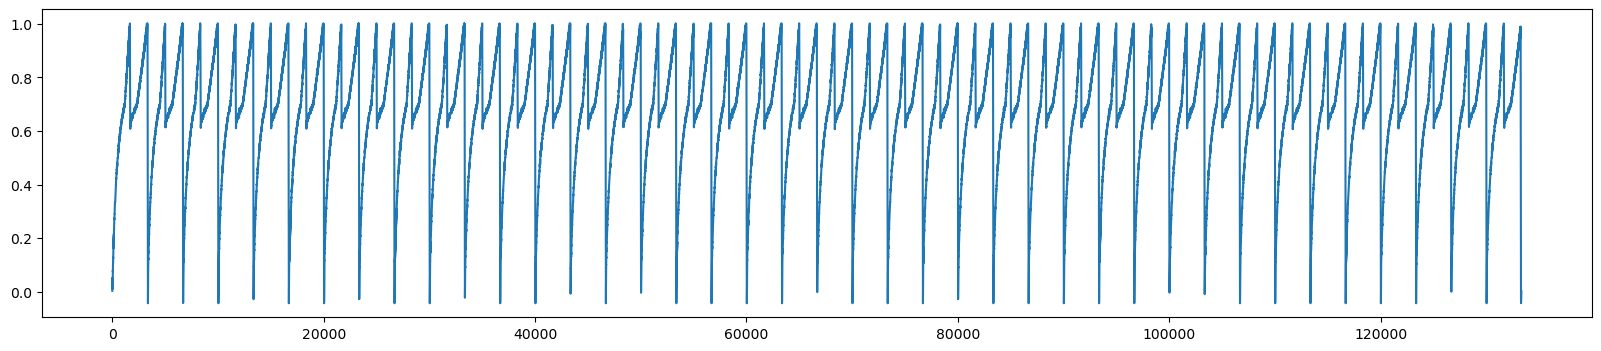

In [268]:
from scipy import signal
sos = signal.butter(2, 18000, 'lp', fs=sr, output='sos')
filtered = signal.sosfilt(sos, bsunpack)
plot(filtered)

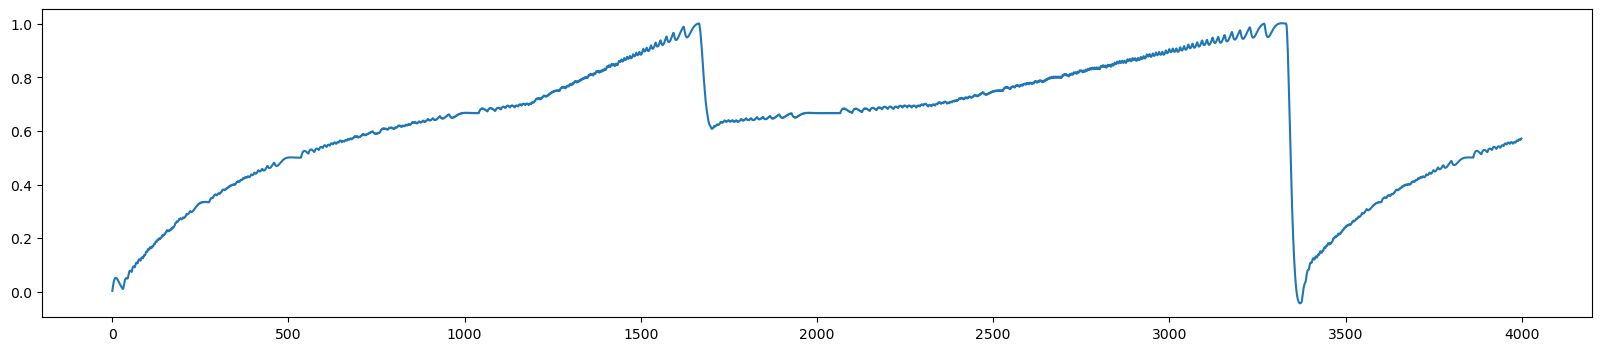

In [269]:
plot(filtered[:4000])

In [273]:
wav = np.tile(librosa.resample(filtered, orig_sr=sr, target_sr=44100),100)
Audio(wav, rate=44100)

In [272]:
import librosa
from IPython.display import Audio

In [262]:
np.tile([1,2,3,4],10)

array([1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2,
       3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4])

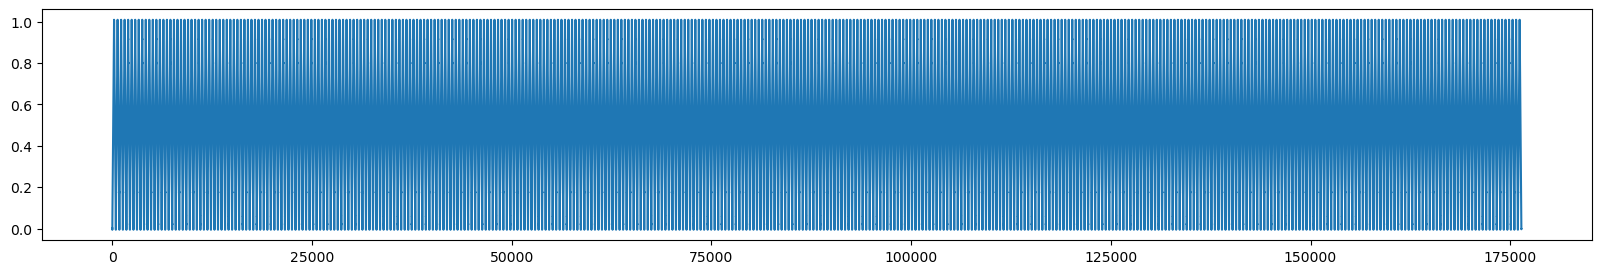

In [325]:

plot(wav)

In [66]:
120003 << 20

125832265728

In [110]:
bs32Processed[100]

3680501760

In [118]:
(bs32[100] << 20) & (pow(2,32) - 1)

3680501760

In [120]:
bs32[100] << 20

1889900959891456

In [338]:
qfp=15

In [339]:
qfpmul=1<<qfp

In [340]:
15*2.4

36.0

In [342]:
bfp = int(2.4*qfpmul)
[bfp]

[78643]

In [345]:
res = 15 * bfp
res

1179645

In [346]:
res >> qfp

35